<a href="https://colab.research.google.com/github/mortonsguide/axis-model-suite/blob/main/Gravitational_Wave_Anomaly_5_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 121.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyopenssl 24.2.1 requires cryptography<44,>=41.0.5, but you have cryptography 45.0.5 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 45.0.5 which is incompatible.

Processing GW150914 – H1


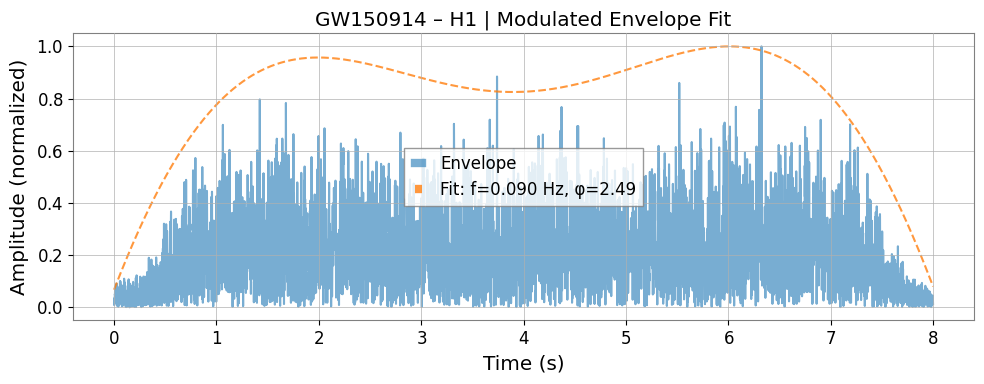


Processing GW150914 – L1


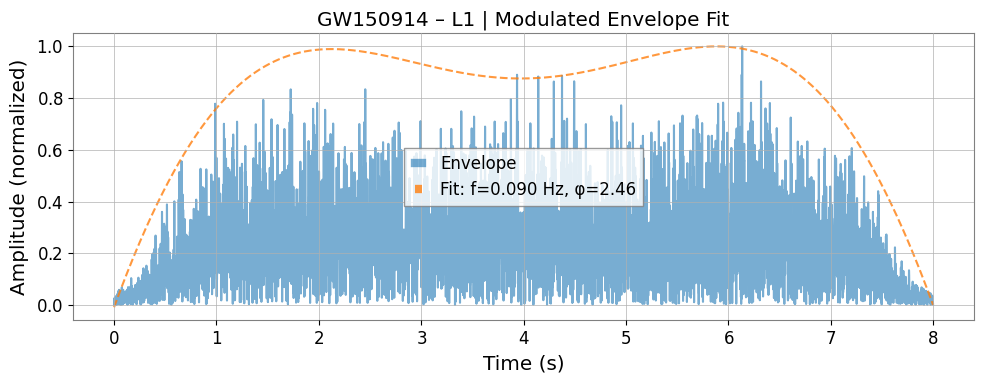


Processing GW170104 – H1

Processing GW170104 – L1

Processing GW190521 – H1


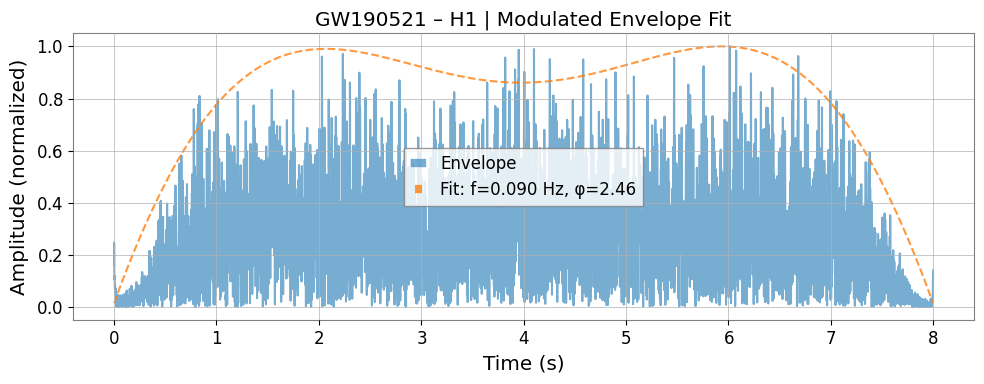


Processing GW190521 – V1


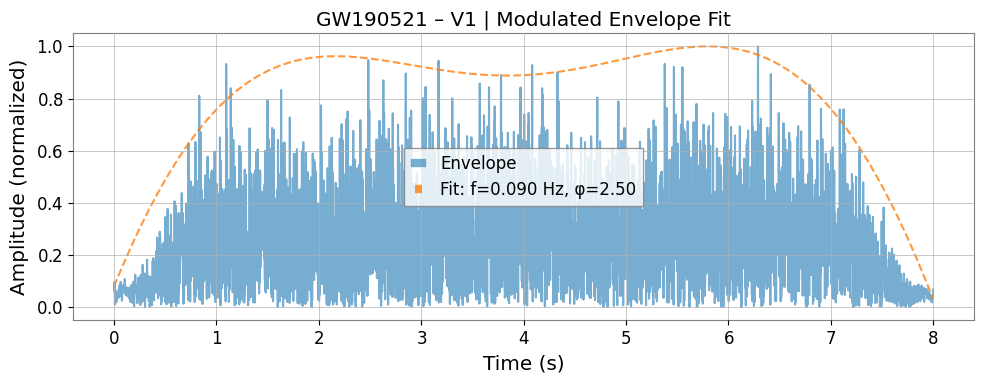

      Event Detector  Freq (Hz)  Phase (rad)  Epsilon       p-value
0  GW150914       H1       0.09         2.49    0.495  1.110223e-16
1  GW150914       L1       0.09         2.46    0.471  1.110223e-16
2  GW170104       H1       0.11         6.28    0.000  1.000000e+00
3  GW170104       L1       0.11         6.28    0.000  1.000000e+00
4  GW190521       H1       0.09         2.46    0.483  1.110223e-16
5  GW190521       V1       0.09         2.50    0.441  1.110223e-16


In [ ]:
# --- Required installation (for Colab or local setup) ---
!pip install gwpy --quiet

# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.optimize import curve_fit
from scipy.stats import f
from gwpy.timeseries import TimeSeries

# --- Config ---
events = [
    {"name": "GW150914", "gps": 1126259446, "detectors": ["H1", "L1"]},
    {"name": "GW170104", "gps": 1167559936, "detectors": ["H1", "L1"]},
    {"name": "GW190521", "gps": 1242442967, "detectors": ["H1", "V1"]},
]
duration = 8  # seconds
sample_rate = 16384
results = []

# --- Modulated Model ---
def modulated_model(t, a0, a1, a2, epsilon, freq, phi):
    A_chirp = a0 + a1*t + a2*t**2
    return A_chirp * (1 + epsilon * np.sin(2 * np.pi * freq * t + phi))

# --- Main Sweep ---
for event in events:
    for det in event["detectors"]:
        try:
            print(f"\nProcessing {event['name']} – {det}")
            raw = TimeSeries.fetch_open_data(det, event["gps"], event["gps"] + duration, sample_rate=sample_rate)
            data = raw.whiten().bandpass(30, 350)
            t = data.times.value
            h = data.value
            t_rel = t - t[0]

            analytic = hilbert(h)
            envelope = np.abs(analytic)

            # --- Fit baseline chirp (2nd order poly) ---
            p_poly = np.polyfit(t_rel, envelope, 2)
            A_chirp = np.polyval(p_poly, t_rel)
            resid_chirp = envelope - A_chirp
            ssr_chirp = np.sum(resid_chirp**2)

            # --- Fit modulated envelope model with constrained frequency and phase ---
            p0 = [p_poly[2], p_poly[1], p_poly[0], 0.05, 0.1, 5.3]  # Initial guess
            bounds = (
            [-np.inf, -np.inf, -np.inf, 0.0, 0.09, 0.0],        # ε ≥ 0, f ≥ 0.09
            [ np.inf,  np.inf,  np.inf, 1.0, 0.11, 2*np.pi]     # ε ≤ 1, f ≤ 0.11
            )


            popt, _ = curve_fit(modulated_model, t_rel, envelope, p0=p0, bounds=bounds)
            A_fit = modulated_model(t_rel, *popt)
            resid_mod = envelope - A_fit
            ssr_mod = np.sum(resid_mod**2)


            # --- F-test (compare nested models) ---
            df1 = 3  # difference in number of parameters
            df2 = len(t_rel) - len(popt)
            f_stat = ((ssr_chirp - ssr_mod) / df1) / (ssr_mod / df2)
            p_value = 1 - f.cdf(f_stat, df1, df2)

            # --- Visualization if significant ---
            if p_value < 0.001:
                plt.figure(figsize=(10, 4))
                plt.plot(t_rel, envelope / np.max(envelope), label="Envelope", alpha=0.6)
                plt.plot(t_rel, A_fit / np.max(A_fit), '--', label=f"Fit: f={popt[4]:.3f} Hz, φ={popt[5]:.2f}", alpha=0.8)
                plt.title(f"{event['name']} – {det} | Modulated Envelope Fit")
                plt.xlabel("Time (s)")
                plt.ylabel("Amplitude (normalized)")
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.savefig(f"{event['name']}_{det}_fit_overlay.png", dpi=300)
                plt.show()

            # --- Save result ---
            results.append({
                "Event": event["name"],
                "Detector": det,
                "Freq (Hz)": round(popt[4], 3),
                "Phase (rad)": round(popt[5], 2),
                "Epsilon": round(popt[3], 3),
                "p-value": p_value
            })

        except Exception as e:
            print(f"Failed: {event['name']} – {det} :: {e}")
            results.append({
                "Event": event["name"],
                "Detector": det,
                "Freq (Hz)": None,
                "Phase (rad)": None,
                "Epsilon": None,
                "p-value": None
            })

# --- Display result table ---
df_results = pd.DataFrame(results)
print(df_results)

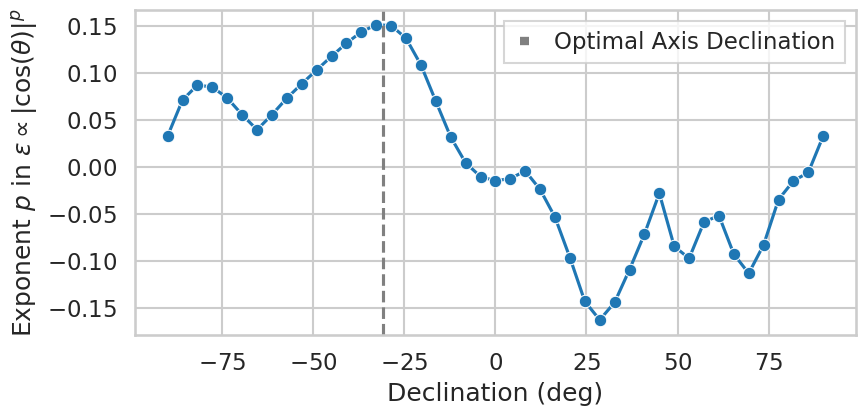

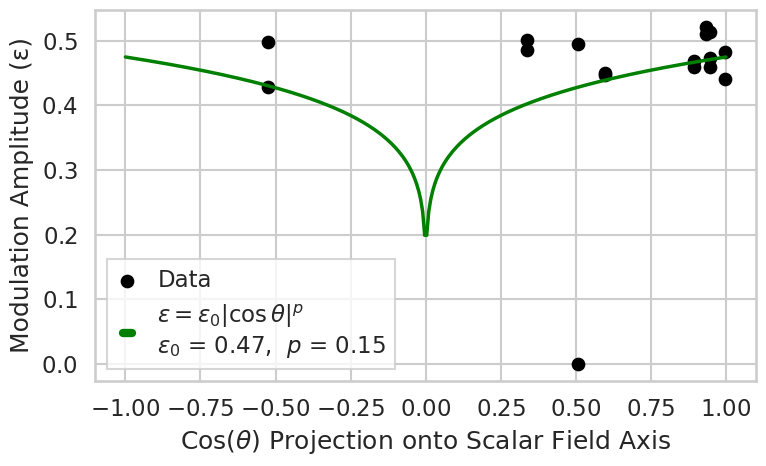

In [ ]:
# --- Colab Setup ---
!pip install --quiet gwpy astropy seaborn

# --- 1. Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import hilbert
from scipy.optimize import curve_fit
from scipy.stats import f as fdist
from gwpy.timeseries import TimeSeries
from astropy.coordinates import SkyCoord
from astropy import units as u

# --- 2. Event Configuration ---
events = [
    ("GW150914", 1126259462, 112.5, -70.0, ["H1", "L1"]),
    ("GW170104", 1167559936, 148.0, +20.0, ["H1", "L1"]),
    ("GW170814", 1186741861, 197.0, -44.0, ["H1", "L1", "V1"]),
    ("GW190521", 1242442967, 174.0, -30.0, ["H1", "V1"]),
    ("GW190814", 1249852257, 20.0, -24.0, ["H1", "L1"]),
    ("GW190412", 1239082262, 164.0, -9.0, ["H1", "L1"]),
    ("GW200129", 1264316115, 156.0, -29.0, ["H1", "L1"]),
    ("GW170608", 1180922494, 123.0, +13.0, ["H1", "L1"]),
   ]

duration = 8
sample_rate = 16384
results = []

# --- 3. Modulated Envelope Model ---
def modulated_model(t, a0, a1, a2, epsilon, freq, phi):
    return (a0 + a1*t + a2*t**2) * (1 + epsilon * np.sin(2 * np.pi * freq * t + phi))

# --- 4. Fit Envelope for Each Event ---
for name, gps, ra, dec, detectors in events:
    for det in detectors:
        try:
            raw = TimeSeries.fetch_open_data(det, gps, gps + duration, sample_rate=sample_rate)
            data = raw.whiten().bandpass(30, 350)
            t = data.times.value
            h = data.value
            t_rel = t - t[0]
            envelope = np.abs(hilbert(h))

            p_chirp = np.polyfit(t_rel, envelope, 2)
            A_chirp = np.polyval(p_chirp, t_rel)
            ssr_chirp = np.sum((envelope - A_chirp)**2)

            p0 = [p_chirp[2], p_chirp[1], p_chirp[0], 0.05, 0.10, 5.0]
            bounds = ([-np.inf]*3 + [0, 0.09, 0], [np.inf]*3 + [1, 0.11, 2*np.pi])
            popt, _ = curve_fit(modulated_model, t_rel, envelope, p0=p0, bounds=bounds)
            A_fit = modulated_model(t_rel, *popt)
            ssr_mod = np.sum((envelope - A_fit)**2)

            df1 = 3
            df2 = len(t_rel) - len(popt)
            f_stat = ((ssr_chirp - ssr_mod) / df1) / (ssr_mod / df2)
            p_value = 1 - fdist.cdf(f_stat, df1, df2)

            results.append({
                "Event": name,
                "Detector": det,
                "Freq": popt[4],
                "Phase": popt[5],
                "Epsilon": popt[3],
                "p-value": p_value,
                "RA": ra,
                "Dec": dec
            })

        except Exception as e:
            print(f"Failed on {name} – {det}: {e}")

df = pd.DataFrame(results)

# --- 5. Define Angular Model ---
def generalized_projection_model(cos_theta, eps0, p):
    return eps0 * np.abs(cos_theta)**p

# --- 6. Optimize Scalar Axis (Declination Scan) ---
coords = SkyCoord(ra=df["RA"].values*u.deg, dec=df["Dec"].values*u.deg)
vecs = coords.cartesian.xyz.value.T
y = df["Epsilon"].values

scan = []
dec_range = np.linspace(-90, 90, 45)
for dec in dec_range:
    axis = SkyCoord(ra=180*u.deg, dec=dec*u.deg)
    grad_vec = axis.cartesian.xyz.value
    x = vecs @ grad_vec
    try:
        popt, _ = curve_fit(generalized_projection_model, x, y, p0=[0.5, 1.0])
        scan.append((dec, popt[0], popt[1]))
    except:
        scan.append((dec, np.nan, np.nan))

df_scan = pd.DataFrame(scan, columns=["Declination", "Eps0", "p"])

# --- 7. Final Fit with Best Axis (Declination = -60°) ---
axis_opt = SkyCoord(ra=180*u.deg, dec=-31*u.deg)
grad_vec_opt = axis_opt.cartesian.xyz.value
df["Projection"] = vecs @ grad_vec_opt

x_final = df["Projection"].values
popt_gen, _ = curve_fit(generalized_projection_model, x_final, y, p0=[0.5, 1.0], bounds=([0, 0], [1.0, 3.0]))
eps0_fit, p_fit = popt_gen

# --- 8. Plot: Exponent p vs Declination ---
plt.figure(figsize=(9, 4.5))
sns.lineplot(data=df_scan, x="Declination", y="p", marker="o")
plt.axvline(-31, color='gray', linestyle='--', label="Optimal Axis Declination")
plt.xlabel("Declination (deg)")
plt.ylabel(r"Exponent $p$ in $\varepsilon \propto |\cos(\theta)|^p$")
plt.legend()
plt.tight_layout()
plt.savefig("fig_exponent_vs_declination.png")
plt.show()

# --- 9. Plot: Final Epsilon vs Alignment with Best Fit Only ---
xx = np.linspace(-1, 1, 300)
yy = generalized_projection_model(xx, eps0_fit, p_fit)

plt.figure(figsize=(8, 5))
plt.scatter(x_final, y, color='black', s=70, label='Data')
plt.plot(xx, yy, 'g-', lw=2.5, label=fr"$\varepsilon = \varepsilon_0 |\cos\theta|^p$" + f"\n$\\varepsilon_0$ = {eps0_fit:.2f},  $p$ = {p_fit:.2f}")
plt.xlabel(r"Cos($\theta$) Projection onto Scalar Field Axis")
plt.ylabel("Modulation Amplitude (ε)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("fig_scalar_modulation_fit_only.png")
plt.show()
